# Phase 1: Data Collection and Preprocessing

In [1]:
!pip install yfinance pandas

In [2]:
import yfinance as yf
import pandas as pd
import os
from datetime import datetime

# Define stock sectors
stock_sectors = {
    "IT": ["TCS.NS", "INFY.NS", "WIPRO.NS"],
    "Banking": ["HDFCBANK.NS", "ICICIBANK.NS", "SBIN.NS"],
    "Pharma": ["SUNPHARMA.NS", "CIPLA.NS", "DRREDDY.NS"]
}

# Set dates
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Create folder to store data
os.makedirs("data/cleaned", exist_ok=True)

# Download and save
for sector, symbols in stock_sectors.items():
    for symbol in symbols:
        df = yf.download(symbol, start=start_date, end=end_date)
        df["Symbol"] = symbol
        df.reset_index(inplace=True)
        df.to_csv(f"data/{sector}_{symbol.replace('.NS','')}_raw.csv", index=False)

/tmp/ipython-input-2-1583921526.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2-1583921526.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2-1583921526.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2-1583921526.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2

In [3]:
import pandas as pd
import glob

# Load all raw CSVs
files = glob.glob("data/*_raw.csv")

for file in files:
    df = pd.read_csv(file)

    # Drop rows with any missing values
    df = df.dropna()

    # Convert date column
    df['Date'] = pd.to_datetime(df['Date'])

    # ✅ Convert 'Volume' column to numeric safely
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # Drop rows where volume is 0 or NaN
    df = df[df['Volume'] > 0]

    # Select relevant columns
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']]

    # Save cleaned version
    name = file.split("/")[-1].replace("_raw", "_cleaned")
    df.to_csv(f"data/cleaned/{name}", index=False)


In [4]:
!pip install pandas_ta
!pip install numpy==1.24.4 --force-reinstall
!pip install --upgrade pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=82e56308aab77cfb6a30975fd74bd3039f67f8009ca9300b82bc6694c406c4bd
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is inc

# Phase 2: Feature Engineering

In [1]:
import pandas as pd
import os
import glob

# === Settings ===
input_path = "data/cleaned"
output_path = "data/features"
os.makedirs(output_path, exist_ok=True)

# === RSI Function (manually coded to avoid pandas_ta issue) ===
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# === Process All Cleaned CSVs ===
files = glob.glob(f"{input_path}/*_cleaned.csv")

for file in files:
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # === TECHNICAL INDICATORS ===
    df["SMA_14"] = df["Close"].rolling(window=14).mean()
    df["EMA_14"] = df["Close"].ewm(span=14, adjust=False).mean()
    df["RSI_14"] = compute_rsi(df["Close"])

    # === LAG FEATURES ===
    df["Close_Lag_1"] = df["Close"].shift(1)
    df["Close_Lag_2"] = df["Close"].shift(2)

    # === ROLLING WINDOW FEATURES ===
    df["Rolling_Mean_7"] = df["Close"].rolling(window=7).mean()
    df["Rolling_Std_7"] = df["Close"].rolling(window=7).std()

    # === TIME FEATURES (for Prophet/LSTM/etc.) ===
    df["Day_of_Week"] = df["Date"].dt.dayofweek
    df["Month"] = df["Date"].dt.month

    # === Drop rows with NaNs ===
    df = df.dropna().reset_index(drop=True)

    # === Save Enhanced CSV ===
    filename = os.path.basename(file).replace("_cleaned.csv", "_features.csv")
    df.to_csv(os.path.join(output_path, filename), index=False)

print("✅ Feature engineering completed for all stocks.")


✅ Feature engineering completed for all stocks.


# Phase 3: Model Building

# Model 1: Baseline Statistical Forecasting using ARIMA

In [2]:
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.9 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("data/features/IT_TCS_features.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
ts = df['Close']

In [4]:
train = ts[:-30]   # Use all except last 30 days
test = ts[-30:]    # Forecast next 30 days


In [5]:
from pmdarima.arima import auto_arima

stepwise_model = auto_arima(train,
                             start_p=1, start_q=1,
                             max_p=5, max_q=5,
                             seasonal=False,
                             d=None, trace=True,
                             error_action='ignore', suppress_warnings=True)
print("Best ARIMA Order:", stepwise_model.order)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13761.529, Time=3.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13757.936, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13759.919, Time=0.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13759.923, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13756.737, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.779 seconds
Best ARIMA Order: (0, 1, 0)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
model = ARIMA(train, order=stepwise_model.order)
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [7]:
forecast = model_fit.forecast(steps=30)
forecast.index = test.index  # align index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


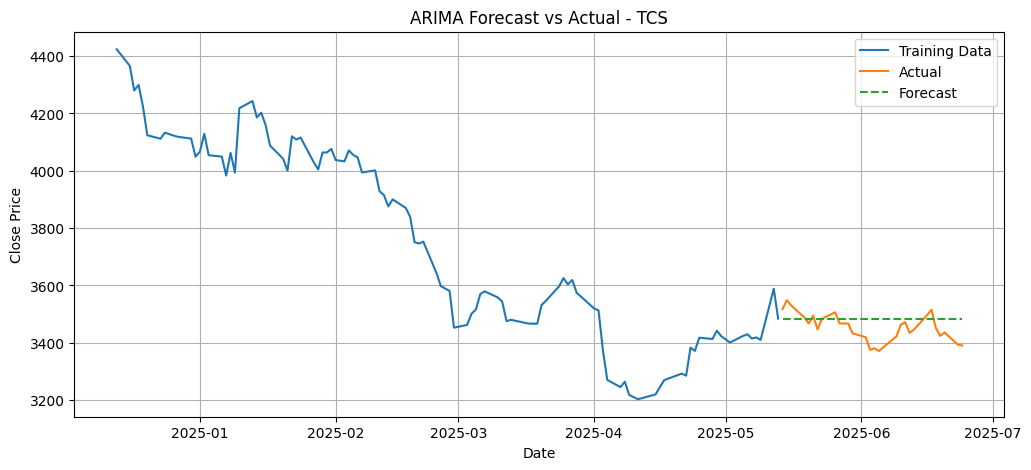

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(train[-100:], label='Training Data')
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("ARIMA Forecast vs Actual - TCS")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid()
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, forecast))  # fixed RMSE
mae = mean_absolute_error(test, forecast)

print(f"✅ Evaluation Results:\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")


✅ Evaluation Results:
RMSE: 56.56
MAE: 45.92


# Model 2: Forecasting with Prophet

In [10]:
!pip install prophet

In [11]:
import pandas as pd

df = pd.read_csv("data/features/IT_TCS_features.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Prophet needs: 'ds' for date, 'y' for target
prophet_df = df[['Date', 'Close']].rename(columns={"Date": "ds", "Close": "y"})

In [12]:
# Last 30 days for testing
train = prophet_df[:-30]
test = prophet_df[-30:]


In [13]:
from prophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpujk_6ntr/xodbibmo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpujk_6ntr/9lcq8t2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23186', 'data', 'file=/tmp/tmpujk_6ntr/xodbibmo.json', 'init=/tmp/tmpujk_6ntr/9lcq8t2x.json', 'output', 'file=/tmp/tmpujk_6ntr/prophet_modelrez31n2g/prophet_model-20250625052136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [14]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

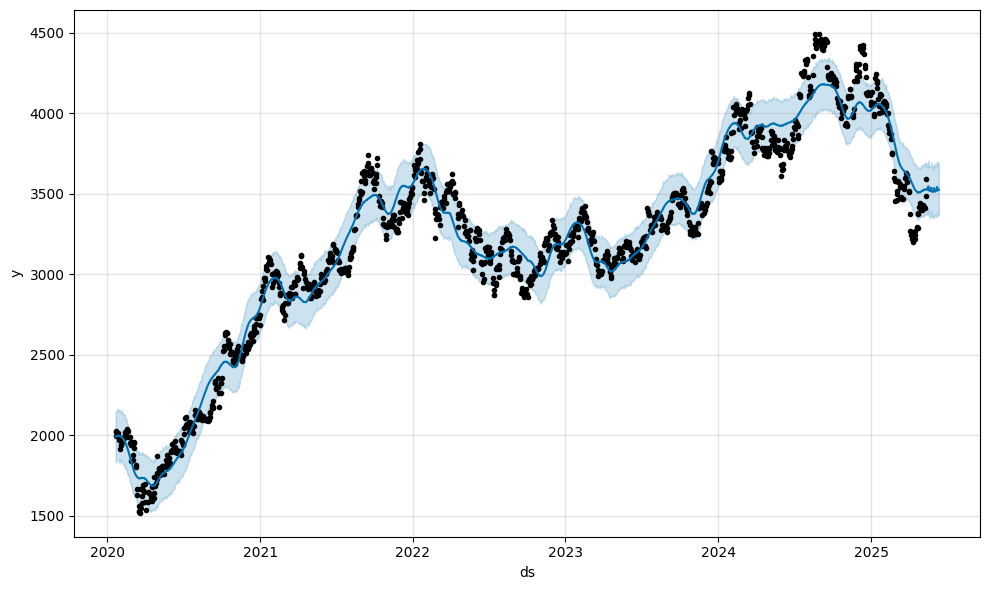

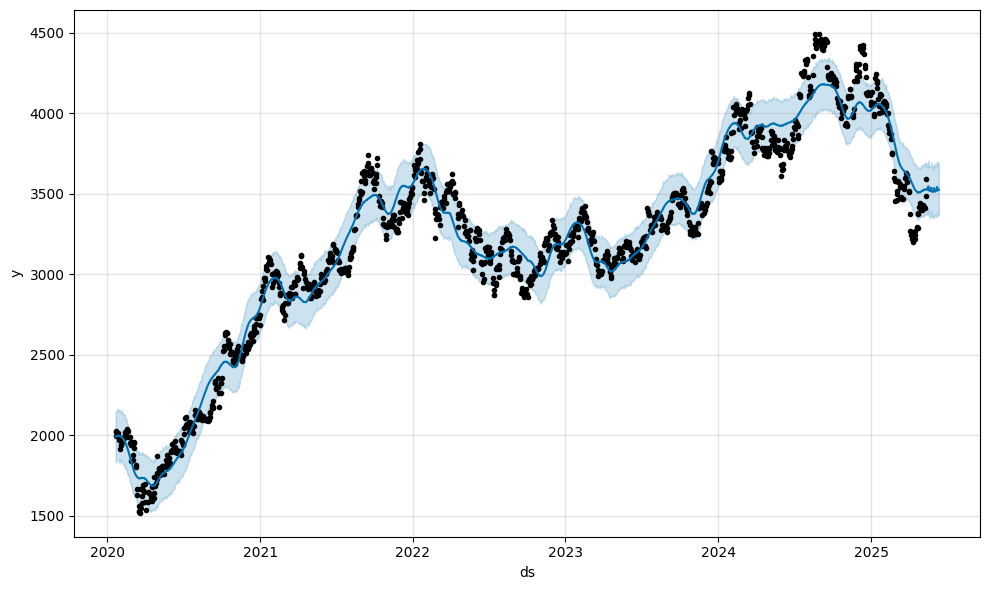

In [15]:
model.plot(forecast)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Match test vs forecast
forecast_tail = forecast[-30:].set_index("ds")["yhat"]
test_tail = test.set_index("ds")["y"]

rmse = np.sqrt(mean_squared_error(test_tail, forecast_tail))
mae = mean_absolute_error(test_tail, forecast_tail)

print(f"📉 Prophet RMSE: {rmse:.2f}, MAE: {mae:.2f}")

📉 Prophet RMSE: 82.98, MAE: 71.10


# Model 3: LSTM Model for Stock Price Forecasting

In [4]:
!pip install numpy==1.24.3
!pip install pandas scikit-learn matplotlib tensorflow

  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

<Axes: title={'center': 'Stock Close Price'}, xlabel='Date'>

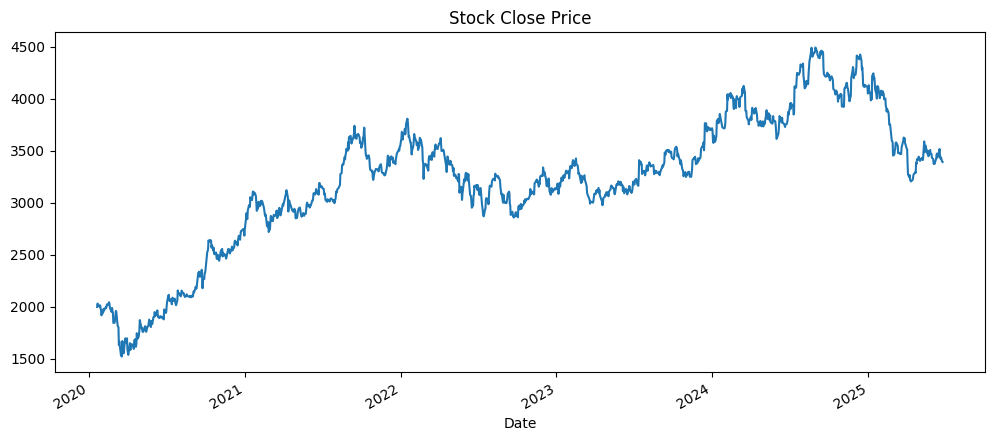

In [2]:
# Upload your stock data (e.g., TCS)
df = pd.read_csv("/content/data/features/IT_TCS_features.csv")

# Parse and set Date
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot to visualize
df['Close'].plot(figsize=(12, 5), title='Stock Close Price')

In [3]:
# Select only 'Close' column
data = df[['Close']].values.astype('float32')

# Normalize prices between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [4]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

seq_len = 60  # Look-back period
X, y = create_sequences(scaled_data, seq_len)

# Train-Test Split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Reshape into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [5]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.1457
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0070
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0052
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0050
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0039
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0039
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0033
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0033
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0033
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0033
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0037
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0036
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0035
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0031
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0035
Epo

In [7]:
y_pred = model.predict(X_test)

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [8]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"✅ LSTM RMSE: {rmse:.2f}, MAE: {mae:.2f}")

✅ LSTM RMSE: 244.65, MAE: 216.78


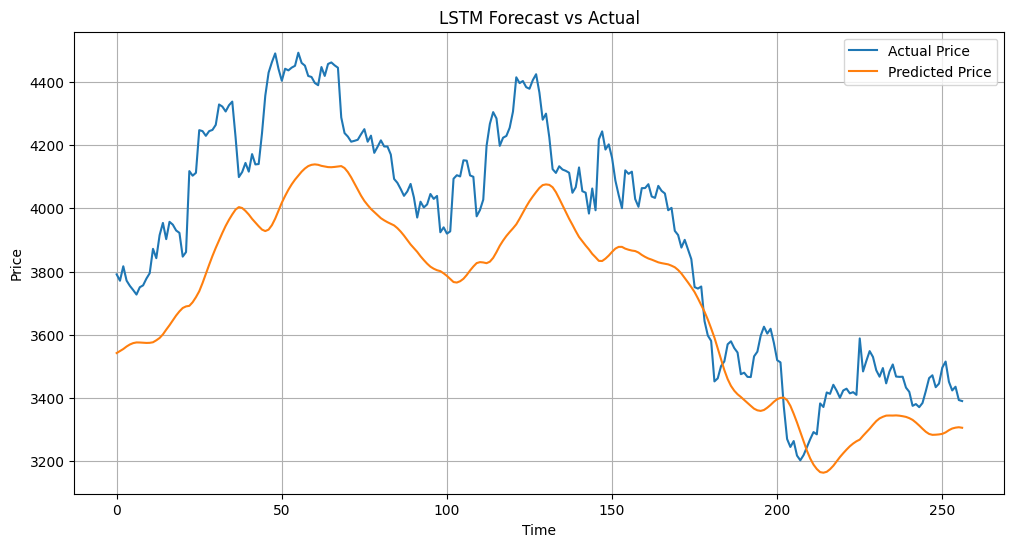

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(y_pred_inv, label="Predicted Price")
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Model for 9 Stocks

In [1]:
!pip uninstall -y numpy tensorflow keras
!pip install numpy==1.23.5
!pip install tensorflow==2.12

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.23.5 which i

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached wrapt-1.14.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.6.2-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.6.2-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [2]:
def run_lstm_forecast(file_path, seq_len=60):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Select Close price
    data = df[['Close']].values.astype('float32')
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    # Create sequences
    def create_sequences(data, seq_len):
        X, y = [], []
        for i in range(seq_len, len(data)):
            X.append(data[i-seq_len:i, 0])
            y.append(data[i, 0])
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    X, y = create_sequences(scaled, seq_len)
    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    X_train = X_train.reshape((-1, seq_len, 1))
    X_test = X_test.reshape((-1, seq_len, 1))

    # LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    return rmse, mae, y_test_inv, y_pred_inv

In [3]:
results = []
files = sorted(os.listdir("data/features"))

for file in files:
    print(f"🚀 Running LSTM on {file}")
    path = os.path.join("data/features", file)
    try:
        rmse, mae, actual, predicted = run_lstm_forecast(path)
        results.append({
            "Stock": file.replace("_features.csv", ""),
            "LSTM_RMSE": round(rmse, 2),
            "LSTM_MAE": round(mae, 2)
        })
    except Exception as e:
        print(f"❌ Failed on {file}: {e}")

# Create summary table
df_results = pd.DataFrame(results)
df_results.to_csv("lstm_9_stocks_results.csv", index=False)
df_results

🚀 Running LSTM on Banking_HDFCBANK_features.csv
9/9 [==============================] - 1s 21ms/step
🚀 Running LSTM on Banking_ICICIBANK_features.csv
9/9 [==============================] - 1s 16ms/step
🚀 Running LSTM on Banking_SBIN_features.csv
9/9 [==============================] - 1s 17ms/step
🚀 Running LSTM on IT_INFY_features.csv
9/9 [==============================] - 1s 17ms/step
🚀 Running LSTM on IT_TCS_features.csv
9/9 [==============================] - 1s 16ms/step
🚀 Running LSTM on IT_WIPRO_features.csv
9/9 [==============================] - 1s 23ms/step
🚀 Running LSTM on Pharma_CIPLA_features.csv
9/9 [==============================] - 1s 18ms/step
🚀 Running LSTM on Pharma_DRREDDY_features.csv
9/9 [==============================] - 1s 17ms/step
🚀 Running LSTM on Pharma_SUNPHARMA_features.csv
9/9 [==============================] - 1s 18ms/step


,Stock,LSTM_RMSE,LSTM_MAE
0,Banking_HDFCBANK,88.19,77.18
1,Banking_ICICIBANK,90.71,84.05
2,Banking_SBIN,23.97,20.21
3,IT_INFY,65.56,54.16
4,IT_TCS,133.52,102.97
5,IT_WIPRO,9.57,7.64
6,Pharma_CIPLA,60.69,51.49
7,Pharma_DRREDDY,46.88,38.24
8,Pharma_SUNPHARMA,97.77,86.44


from matplotlib import pyplot as plt
df_results['LSTM_RMSE'].plot(kind='hist', bins=20, title='LSTM_RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['LSTM_MAE'].plot(kind='hist', bins=20, title='LSTM_MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results.plot(kind='scatter', x='LSTM_RMSE', y='LSTM_MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_results['LSTM_RMSE'].plot(kind='line', figsize=(8, 4), title='LSTM_RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_results['LSTM_MAE'].plot(kind='line', figsize=(8, 4), title='LSTM_MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

# Phase 4: Visualization

In [12]:
pip install dash pandas plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, 

In [17]:
import os
os.makedirs("lstm_results", exist_ok=True)

In [40]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# ⚙️ Step 1: Load your preprocessed stock data (TCS example)
df = pd.read_csv("/content/data/features/Banking_features.csv")  # Update path if needed
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)

# 🧼 Step 2: Scale 'Close' column using MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(df[['Close']].values)

# 🔁 Step 3: Create sequences
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(data, seq_len)

# 🧪 Step 4: Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 📐 Reshape input for LSTM [samples, time_steps, features]
X_train = X_train.reshape(-1, seq_len, 1)
X_test = X_test.reshape(-1, seq_len, 1)

# 🧠 Step 5: Build & train LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_len, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# 📈 Step 6: Predict on test data
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 📁 Step 7: Save test predictions
forecast_dates = df.index[-len(y_test_inv):]
results_df = pd.DataFrame({
    "Stock": "IT_WIPRO",
    "Date": forecast_dates,
    "Actual": y_test_inv.flatten(),
    "Predicted": y_pred_inv.flatten()
})

os.makedirs("lstm_results", exist_ok=True)
results_df.to_csv("/content/data/app.py/lstm_results/IT_WIPRO_forecast.csv", index=False)
print("✅ Test predictions saved to lstm_results/IT_TCS_forecast.csv")

# 🔮 Step 8: Predict next 30 future days
last_seq = data[-seq_len:]
future_preds = []

for _ in range(30):
    input_seq = last_seq.reshape(1, seq_len, 1)
    next_pred = model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(next_pred)
    last_seq = np.append(last_seq[1:], next_pred)

future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 📅 Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# 📁 Save future forecast
future_df = pd.DataFrame({
    "Stock": "IT_WIPRO",
    "Date": future_dates,
    "Predicted": future_preds.flatten()
})
future_df.to_csv("/content/data/app.py/lstm_results/IT_WIPRO_future_forecast.csv", index=False)
print("🔮 Future forecast saved to lstm_results/IT_TCS_future_forecast.csv")

Epoch 1/5
33/33 [==============================] - 8s 67ms/step - loss: 0.0362
Epoch 2/5
33/33 [==============================] - 3s 96ms/step - loss: 0.0059
Epoch 3/5
33/33 [==============================] - 2s 64ms/step - loss: 0.0045
Epoch 4/5
33/33 [==============================] - 2s 66ms/step - loss: 0.0042
Epoch 5/5
9/9 [==============================] - 1s 17ms/step
✅ Test predictions saved to lstm_results/IT_TCS_forecast.csv
🔮 Future forecast saved to lstm_results/IT_TCS_future_forecast.csv
